### Denoising Autoencoders And Where To Find Them (5 points)

Today we're going to train deep autoencoders and deploy them to faces and search for similar images.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

In [1]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 256.0

img_shape = X.shape[1:]

X_train, X_test = train_test_split(X, test_size=0.1,random_state=42)

images not found, donwloading...
extracting...
done


X shape: (13143, 38, 38, 3)
attr shape: (13143, 73)


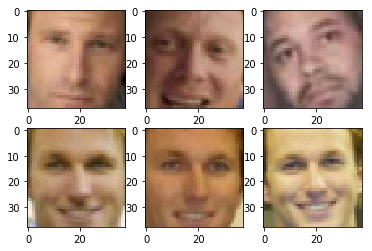

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.title('sample image')
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(X[i])

print("X shape:",X.shape)
print("attr shape:",attr.shape)

### Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train those models.

<img src="http://nghiaho.com/wp-content/uploads/2012/12/autoencoder_network1.png" width=640px>



In [4]:
import tensorflow as tf
import keras, keras.layers as L
s = keras.backend.get_session()

/opt/conda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


## First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [5]:
def build_pca_autoencoder(img_shape,code_size=32):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model

In [6]:
encoder,decoder = build_pca_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [7]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 5s 410us/step - loss: 0.0266 - val_loss: 0.0170
Epoch 2/32
11828/11828 [==============================] - 5s 398us/step - loss: 0.0156 - val_loss: 0.0144
Epoch 3/32
11828/11828 [==============================] - 5s 399us/step - loss: 0.0129 - val_loss: 0.0119
Epoch 4/32
11828/11828 [==============================] - 5s 399us/step - loss: 0.0109 - val_loss: 0.0103
Epoch 5/32
11828/11828 [==============================] - 5s 397us/step - loss: 0.0095 - val_loss: 0.0092
Epoch 6/32
11828/11828 [==============================] - 5s 398us/step - loss: 0.0085 - val_loss: 0.0082
Epoch 7/32
11828/11828 [==============================] - 5s 399us/step - loss: 0.0076 - val_loss: 0.0072
Epoch 8/32
11828/11828 [==============================] - 5s 397us/step - loss: 0.0067 - val_loss: 0.0065
Epoch 9/32
11828/11828 [==============================] - 5s 397us/step - loss: 0.0062 - val_loss: 0.00

In [8]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()


Final MSE: 0.00563257612012


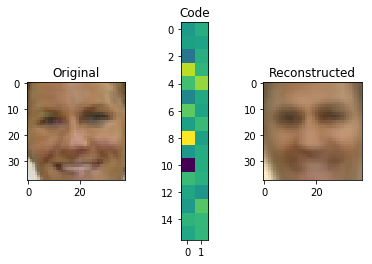

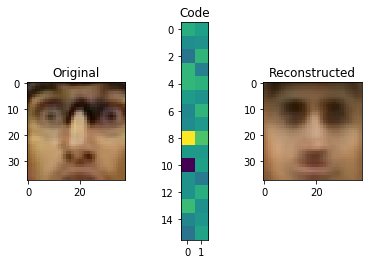

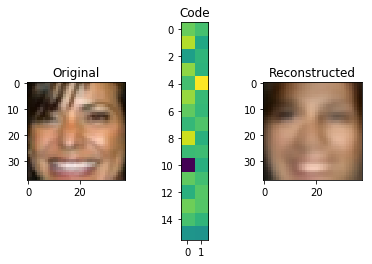

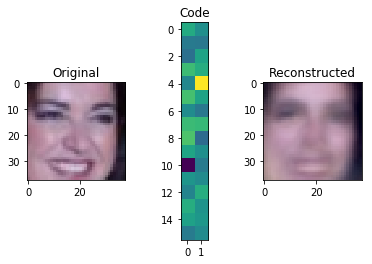

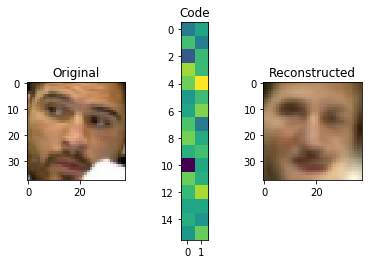

In [9]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("Final MSE:",score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)


### Going deeper

PCA is neat but surely we can do better. This time we want you to build a deep autoencoder by... stacking more layers.

In particular, your encoder and decoder should be at least 3 layers deep each. You can use any nonlinearity you want and any number of hidden units in non-bottleneck layers provided you can actually afford training it.

![layers](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

A few sanity checks:
* There shouldn't be any hidden layer smaller than bottleneck (encoder output).
* Don't forget to insert nonlinearities between intermediate dense layers.
* Convolutional layers are allowed but not required. To undo convolution use L.Deconv2D, pooling - L.UpSampling2D.
* Adding activation after bottleneck is allowed, but not strictly necessary.

In [10]:
np.prod(img_shape)//36

120

In [11]:
img_prod = np.prod(img_shape)
img_shape, 

((38, 38, 3),)

In [12]:
from keras import layers
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    
    img_prod = np.prod(img_shape)
    
    l_dim1 = img_prod   
    l_dim2 = code_size*8
    l_dim3 = code_size*2
    l_dim4 = code_size*1
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    print(encoder.output_shape)
    
    encoder.add(L.Conv2D(8,3, padding="same", input_shape=(38, 38, 3)))
    print(encoder.output_shape)
    encoder.add(L.BatchNormalization())
    encoder.add(L.LeakyReLU(0.1))
    encoder.add(L.Conv2D(16,3, padding="same", input_shape=(38, 38, 8)))
    print(encoder.output_shape)
    encoder.add(L.BatchNormalization())
    encoder.add(L.LeakyReLU(0.1))
    encoder.add(L.MaxPooling2D())
    print(encoder.output_shape)
    MaxPool_shape1 = encoder.output_shape[1:]
    print("MaxPool_shape1", MaxPool_shape1)
    
    encoder.add(L.Conv2D(32,3, padding="same", input_shape=(19,19,16)))
    print(encoder.output_shape)
    encoder.add(L.BatchNormalization())
    encoder.add(L.LeakyReLU(0.1))
    encoder.add(L.Conv2D(64,3, padding="same", input_shape=(19, 19, 32)))
    print(encoder.output_shape)
    encoder.add(L.BatchNormalization())
    encoder.add(L.LeakyReLU(0.1))
    encoder.add(L.MaxPooling2D())
    print(encoder.output_shape)
    MaxPool_shape2 = encoder.output_shape[1:]
    
    encoder.add(L.Flatten())    
    Flatten_shape = encoder.output_shape[1]
    print(encoder.output_shape)         
    print("FLAT", Flatten_shape)
    
#     encoder.add(L.Dense(l_dim1))        
#     encoder.add(L.LeakyReLU(0.1))
#     print(encoder.output_shape)     
#     encoder.add(L.Dense(l_dim2))         
#     encoder.add(L.LeakyReLU(0.1))    
#     print(encoder.output_shape)          
    encoder.add(L.Dense(l_dim3))          
    encoder.add(L.LeakyReLU(0.1))
    print(encoder.output_shape)         

    encoder.add(L.Dense(code_size))      
    print(encoder.output_shape)        
    
    print('')
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    print("dec",decoder.output_shape)   
    decoder.add(L.Dense(l_dim3))          
    decoder.add(L.LeakyReLU(0.1))
    print("dec",decoder.output_shape)  
#     decoder.add(L.Dense(l_dim2))             
#     decoder.add(L.LeakyReLU(0.1))    
#     print("dec",decoder.output_shape) 
#     decoder.add(L.Dense(l_dim1))
#     print("dec",decoder.output_shape)   
#     decoder.add(L.LeakyReLU(0.1))    

    decoder.add(L.Dense(Flatten_shape))
    print("dec",decoder.output_shape)   
    
    decoder.add(L.Reshape(MaxPool_shape2))
    print("dec",decoder.output_shape)   
    decoder.add(L.UpSampling2D())
    print("dec",decoder.output_shape)   
    decoder.add(L.Deconv2D(32, 3, padding='same'))
    print("dec",decoder.output_shape)   
    decoder.add(L.Deconv2D(16, 3, padding='same'))
    print("dec",decoder.output_shape)   
    
    decoder.add(L.Reshape(MaxPool_shape1))
    print("dec",decoder.output_shape)   
    decoder.add(L.UpSampling2D())
    print("dec",decoder.output_shape)   
    decoder.add(L.Deconv2D(8, 3, padding='same'))
    print("dec",decoder.output_shape)   
    decoder.add(L.Deconv2D(3, 3, padding='same'))
    print("dec",decoder.output_shape)   
    
    return encoder,decoder

In [16]:
from keras import layers
def build_deep_autoencoder(img_shape,code_size=32):
    """PCA's deeper brother. See instructions above"""
    H,W,C = img_shape
    
    
    img_prod = np.prod(img_shape)
    
    l_dim1 = img_prod   
    l_dim2 = code_size*8
    l_dim3 = code_size*2
    l_dim4 = code_size*1
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    encoder.add(L.Flatten())   
    
    encoder.add(L.Dense(code_size*4))     
    encoder.add(L.LeakyReLU(0.1))
    encoder.add(L.Dense(code_size*2))         
    encoder.add(L.LeakyReLU(0.1))

    encoder.add(L.Dense(code_size))      
    
    print('')
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))

    decoder.add(L.Dense(code_size*2))          
    decoder.add(L.LeakyReLU(0.1))
    decoder.add(L.Dense(code_size*4))          
    decoder.add(L.LeakyReLU(0.1))
    decoder.add(L.Dense(np.prod(img_shape)))          
    decoder.add(L.Reshape(img_shape))
    
    
    return encoder,decoder

In [17]:
#Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512,1024]:
    encoder,decoder = build_deep_autoencoder(img_shape,code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==img_shape,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 dense layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 dense layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")


Testing code size 1

Testing code size 8

Testing code size 32

Testing code size 128

Testing code size 512

Testing code size 1024
All tests passed!


__Hint:__ if you're getting "Encoder layer is smaller than bottleneck" error, use code_size when defining intermediate layers. 

For example, such layer may have code_size*2 units.

In [18]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=32)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

Training may take some 20 minutes.

In [19]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 9s 785us/step - loss: 0.0216 - val_loss: 0.0141
Epoch 2/32
11828/11828 [==============================] - 8s 713us/step - loss: 0.0121 - val_loss: 0.0112
Epoch 3/32
11828/11828 [==============================] - 8s 715us/step - loss: 0.0106 - val_loss: 0.0101
Epoch 4/32
11828/11828 [==============================] - 8s 714us/step - loss: 0.0095 - val_loss: 0.0096
Epoch 5/32
11828/11828 [==============================] - 8s 713us/step - loss: 0.0090 - val_loss: 0.0090
Epoch 6/32
11828/11828 [==============================] - 8s 714us/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/32
11828/11828 [==============================] - 8s 711us/step - loss: 0.0082 - val_loss: 0.0082
Epoch 8/32
11828/11828 [==============================] - 8s 716us/step - loss: 0.0079 - val_loss: 0.0080
Epoch 9/32
11828/11828 [==============================] - 8s 713us/step - loss: 0.0077 - val_loss: 0.00

In [20]:
autoencoder.fit(x=X_train,y=X_train,epochs=5,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/5
11828/11828 [==============================] - 8s 714us/step - loss: 0.0058 - val_loss: 0.0060
Epoch 2/5
11828/11828 [==============================] - 8s 714us/step - loss: 0.0057 - val_loss: 0.0059
Epoch 3/5
11828/11828 [==============================] - 8s 713us/step - loss: 0.0057 - val_loss: 0.0059: 0
Epoch 4/5
11828/11828 [==============================] - 8s 712us/step - loss: 0.0057 - val_loss: 0.0059
Epoch 5/5
11828/11828 [==============================] - 8s 711us/step - loss: 0.0057 - val_loss: 0.0059


In [ ]:
Получилось только с code_size=64 =(

encoder,decoder = build_deep_autoencoder(img_shape,code_size=64)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')reconstruction_mse = autoencoder.evaluate(X_test,X_test,verbose=0)
assert reconstruction_mse <= 0.005, "Compression is too lossy. See tips below."
assert len(encoder.output_shape)==2 and encoder.output_shape[1]==32, "Make sure encoder has code_size units"
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [20]:
autoencoder.fit(x=X_train,y=X_train,epochs=200,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/200
11828/11828 [==============================] - 30s - loss: 0.0280 - val_loss: 0.0173
Epoch 2/200
11828/11828 [==============================] - 32s - loss: 0.0155 - val_loss: 0.0137
Epoch 3/200
11828/11828 [==============================] - 32s - loss: 0.0133 - val_loss: 0.0127
Epoch 4/200
11828/11828 [==============================] - 32s - loss: 0.0123 - val_loss: 0.0116
Epoch 5/200
11828/11828 [==============================] - 30s - loss: 0.0111 - val_loss: 0.0107
Epoch 6/200
11828/11828 [==============================] - 29s - loss: 0.0107 - val_loss: 0.0104
Epoch 7/200
11828/11828 [==============================] - 34s - loss: 0.0103 - val_loss: 0.0100
Epoch 8/200
11828/11828 [==============================] - 35s - loss: 0.0100 - val_loss: 0.0097
Epoch 9/200
11828/11828 [==============================] - 38s - loss: 0.0097 - val_loss: 0.0094
Epoch 10/200
11828/11828 [==============================] - 39s - loss: 0.0094

KeyboardInterrupt: 

In [16]:
autoencoder.fit(x=X_train,y=X_train,epochs=200,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/200
11828/11828 [==============================] - 103s - loss: 0.0267 - val_loss: 0.0164
Epoch 2/200
11828/11828 [==============================] - 107s - loss: 0.0158 - val_loss: 0.0154
Epoch 3/200
11828/11828 [==============================] - 109s - loss: 0.0145 - val_loss: 0.0133
Epoch 4/200
11828/11828 [==============================] - 113s - loss: 0.0139 - val_loss: 0.0129
Epoch 5/200
11828/11828 [==============================] - 113s - loss: 0.0134 - val_loss: 0.0127
Epoch 6/200
11828/11828 [==============================] - 105s - loss: 0.0130 - val_loss: 0.0119
Epoch 7/200
11828/11828 [==============================] - 103s - loss: 0.0126 - val_loss: 0.0121
Epoch 8/200
11828/11828 [==============================] - 103s - loss: 0.0124 - val_loss: 0.0120
Epoch 9/200
11828/11828 [==============================] - 102s - loss: 0.0121 - val_loss: 0.0113
Epoch 10/200
11828/11828 [==============================] - 103s - lo

KeyboardInterrupt: 

In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=200,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/200
11828/11828 [==============================] - 89s - loss: 0.0245 - val_loss: 0.0174
Epoch 2/200
 4480/11828 [==========>...................] - ETA: 54s - loss: 0.0170

In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=120,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/120
11828/11828 [==============================] - 199s - loss: 0.0235 - val_loss: 0.0171
Epoch 2/120
11828/11828 [==============================] - 202s - loss: 0.0153 - val_loss: 0.0135
Epoch 3/120
11828/11828 [==============================] - 208s - loss: 0.0131 - val_loss: 0.0128
Epoch 4/120
11828/11828 [==============================] - 211s - loss: 0.0128 - val_loss: 0.0121
Epoch 5/120
11828/11828 [==============================] - 212s - loss: 0.0120 - val_loss: 0.0114
Epoch 6/120
11828/11828 [==============================] - 211s - loss: 0.0111 - val_loss: 0.0108
Epoch 7/120
11828/11828 [==============================] - 216s - loss: 0.0106 - val_loss: 0.0103
Epoch 8/120
11828/11828 [==============================] - 211s - loss: 0.0103 - val_loss: 0.0102
Epoch 9/120
11828/11828 [==============================] - 209s - loss: 0.0100 - val_loss: 0.0098
Epoch 10/120
11828/11828 [==============================] - 209s - lo

In [73]:
autoencoder.fit(x=X_train,y=X_train,epochs=64,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/64
11828/11828 [==============================] - 49s - loss: 0.0235 - val_loss: 0.0167
Epoch 2/64
11828/11828 [==============================] - 47s - loss: 0.0153 - val_loss: 0.0138
Epoch 3/64
11828/11828 [==============================] - 47s - loss: 0.0133 - val_loss: 0.0125
Epoch 4/64
11828/11828 [==============================] - 49s - loss: 0.0120 - val_loss: 0.0114
Epoch 5/64
11828/11828 [==============================] - 48s - loss: 0.0113 - val_loss: 0.0108
Epoch 6/64
11828/11828 [==============================] - 47s - loss: 0.0107 - val_loss: 0.0102
Epoch 7/64
11828/11828 [==============================] - 48s - loss: 0.0102 - val_loss: 0.0100
Epoch 8/64
11828/11828 [==============================] - 52s - loss: 0.0099 - val_loss: 0.0097
Epoch 9/64
11828/11828 [==============================] - 53s - loss: 0.0096 - val_loss: 0.0094
Epoch 10/64
11828/11828 [==============================] - 55s - loss: 0.0093 - val_los

In [15]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 201s - loss: 0.0182 - val_loss: 0.1179
Epoch 2/32
11828/11828 [==============================] - 201s - loss: 0.0109 - val_loss: 0.0143
Epoch 3/32
10784/11828 [==========================>...] - ETA: 19s - loss: 0.0100

KeyboardInterrupt: 

In [ ]:
autoencoder.fit(x=X_train,y=X_train,epochs=200,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/200
11828/11828 [==============================] - 21s - loss: 0.0288 - val_loss: 0.0175
Epoch 2/200
11828/11828 [==============================] - 21s - loss: 0.0156 - val_loss: 0.0138
Epoch 3/200
11828/11828 [==============================] - 22s - loss: 0.0133 - val_loss: 0.0122
Epoch 4/200
11828/11828 [==============================] - 22s - loss: 0.0117 - val_loss: 0.0112
Epoch 5/200
11828/11828 [==============================] - 24s - loss: 0.0111 - val_loss: 0.0107
Epoch 6/200
11828/11828 [==============================] - 25s - loss: 0.0106 - val_loss: 0.0102
Epoch 7/200
11828/11828 [==============================] - 27s - loss: 0.0101 - val_loss: 0.0099
Epoch 8/200
11828/11828 [==============================] - 23s - loss: 0.0098 - val_loss: 0.0095
Epoch 9/200
11828/11828 [==============================] - 20s - loss: 0.0095 - val_loss: 0.0092
Epoch 10/200
11828/11828 [==============================] - 20s - loss: 0.0092

__Tips:__ If you keep getting "Compression to lossy" error, there's a few things you might try:

* Make sure it converged. Some architectures need way more than 32 epochs to converge. They may fluctuate a lot, but eventually they're going to get good enough to pass. You may train your network for as long as you want.

* Complexity. If you already have, like, 152 layers and still not passing threshold, you may wish to start from something simpler instead and go in small incremental steps.

* Architecture. You can use any combination of layers (including convolutions, normalization, etc) as long as __encoder output only stores 32 numbers per training object__. 

A cunning learner can circumvent this last limitation by using some manual encoding strategy, but he is strongly recommended to avoid that.

Получилось только с code_size=64 =(

In [21]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=64)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [22]:
autoencoder.fit(x=X_train,y=X_train,epochs=32,
                validation_data=[X_test,X_test])

Train on 11828 samples, validate on 1315 samples
Epoch 1/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0185 - val_loss: 0.0119
Epoch 2/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0104 - val_loss: 0.0100
Epoch 3/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0090 - val_loss: 0.0087
Epoch 4/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0082 - val_loss: 0.0079
Epoch 5/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0077 - val_loss: 0.0075
Epoch 6/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0072 - val_loss: 0.0073
Epoch 7/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0067 - val_loss: 0.0067
Epoch 8/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0064 - val_loss: 0.0063
Epoch 9/32
11828/11828 [==============================] - 14s 1ms/step - loss: 0.0061 - val_loss: 0.0064
Epoch 

## Denoising AutoEncoder

Let's now make our model into a denoising autoencoder.

We'll keep your model architecture, but change the way it trains. In particular, we'll corrupt it's input data randomly before each epoch.

There are many strategies to apply noise. We'll implement two popular one: adding gaussian noise and using dropout.

In [23]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    """
    
    noise = np.random.normal(0,sigma,X.shape)
        
    return X + noise
    

In [24]:
#noise tests
theoretical_std = (X[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X[:100],sigma=0.5).mean() - X[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

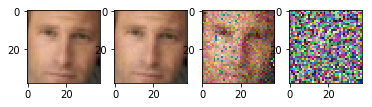

In [25]:
plt.subplot(1,4,1)
plt.imshow(X[0])
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X[:1],sigma=0.5)[0])

In [26]:
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

In [27]:
for i in range(50):
    print("Epoch %i/50, Generating corrupted samples..."%i)
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    autoencoder.fit(x=X_train_noise,y=X_train,epochs=1,
                    validation_data=[X_test_noise,X_test])

Epoch 0/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 122s 10ms/step - loss: 0.1240 - val_loss: 0.0191
Epoch 1/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 122s 10ms/step - loss: 0.0158 - val_loss: 0.0141
Epoch 2/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 122s 10ms/step - loss: 0.0128 - val_loss: 0.0123
Epoch 3/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 122s 10ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 4/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 121s 10ms/step - loss: 0.0101 - val_loss: 0.0098
Epoch

Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 187s 16ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 42/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 155s 13ms/step - loss: 0.0030 - val_loss: 0.0041
Epoch 43/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 155s 13ms/step - loss: 0.0030 - val_loss: 0.0036
Epoch 44/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 160s 13ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 45/50, Generating corrupted samples...
Train on 11828 samples, validate on 1315 samples
Epoch 1/1
11828/11828 [==============================] - 165s 14ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 46/50, Generating corrupted samples...


# __Note:__ if it hasn't yet converged, increase the number of iterations.

__Bonus:__ replace gaussian noise with masking random rectangles on image.

Final MSE: 0.0037223131086


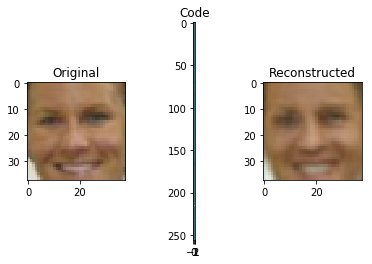

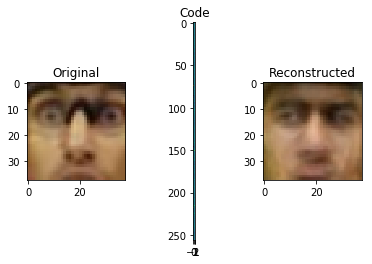

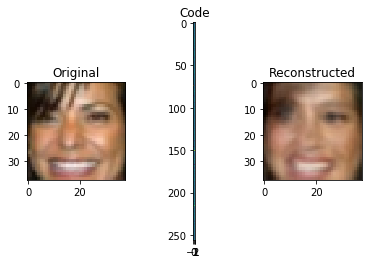

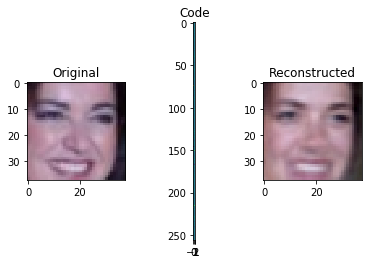

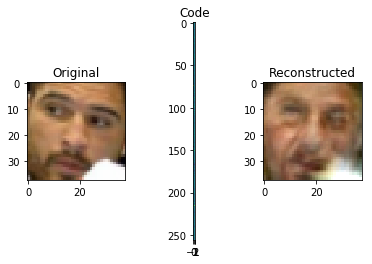

In [39]:
denoising_mse = autoencoder.evaluate(apply_gaussian_noise(X_test),X_test,verbose=0)
print("Final MSE:", denoising_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [40]:
encoder.save("./encoder.h5")
decoder.save("./decoder.h5")

### Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see it in action.

First thing we can do is image retrieval aka image search. We we give it an image and find similar images in latent space. 

To speed up retrieval process, we shall use Locality-Sensitive Hashing on top of encoded vectors. We'll use scikit-learn's implementation for simplicity. In practical scenario, you may want to use [specialized libraries](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) for better performance and customization.

In [41]:
images = X_train
codes = [encoder.predict(img[None])[0] for img in X_train]
assert len(codes) == len(images)

In [42]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

In [43]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [44]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image)
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

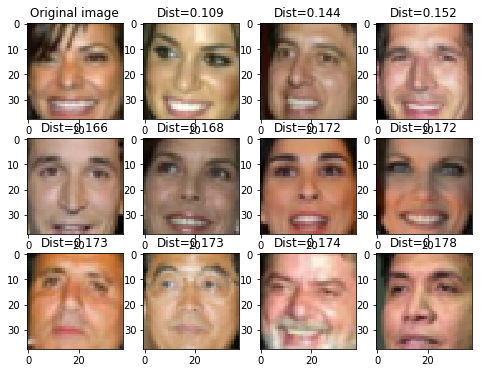

In [45]:
#smiles
show_similar(X_test[2])

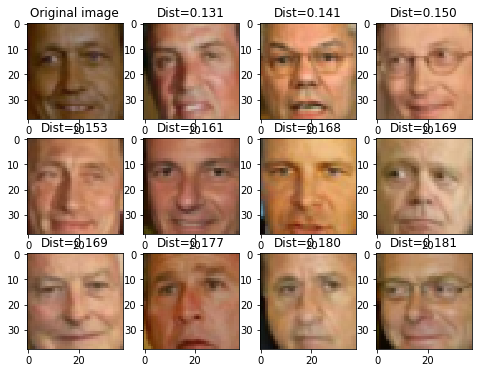

In [46]:
#ethnicity
show_similar(X_test[500])

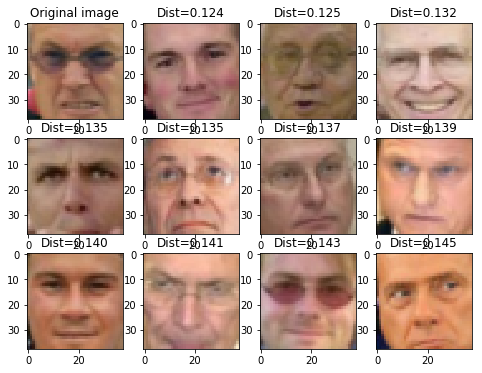

In [ ]:
#glasses
show_similar(X_test[66])

## Bonus: cheap image morphing


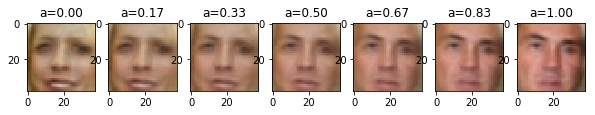

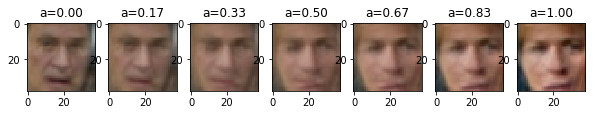

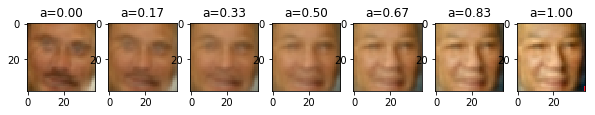

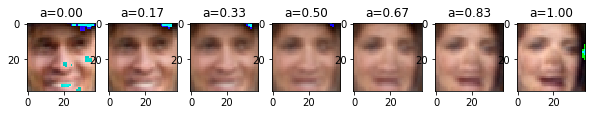

In [ ]:

for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1,image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        plt.imshow(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track seminar about generative adversarial networks.